In [1]:
import os
import sys
sys.path.append("..")
import dnnlib
import legacy
import pickle
import torch

import PIL.Image as Image
from training.camera_utils import *
import math
from notebook_utils import *

import numpy as np
import glob
import random

## Load the Checkpoints

In [2]:
device = "cuda"
model_path = "/share/phoenix/nfs04/S7/emc348/stylegan3/training-runs/00322-raycond2-cars_train-gpus2-batch32-gamma0.3/network-snapshot-015120.pkl"

In [3]:
with open(model_path, 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda().eval()

## Initialize the Camera Parameters

In [21]:
cam_pivot = torch.tensor([0., 0., 0.], device=device)
cam_radius = 1.3
focal_length = 1.7074
intrinsics = torch.tensor([[focal_length, 0, 0.5], [0, focal_length, 0.5], [0, 0, 1]], device=device) # Intrinsics are resolution invariant

c2w = LookAtPoseSampler.sample(np.pi / 2, np.pi / 2, cam_pivot, radius=cam_radius, device=device)
c2w = UniformBlenderPoseSampler.sample(0, 0, radius=1.3, device=device)
c = torch.cat([c2w.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)

In [5]:
c2w

tensor([[[ 0.8334, -0.3228,  0.4486, -0.4486],
         [-0.5527, -0.4867,  0.6765, -0.6765],
         [ 0.0000, -0.8117, -0.5841,  0.5841],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0')

In [23]:
c2w = torch.tensor([-9.1294e-01, -2.6523e-07, -4.0808e-01,  5.3051e-01,  4.0808e-01,
        -4.6273e-07, -9.1295e-01,  1.1868e+00,  1.2454e-07, -1.0000e+00,
         1.9678e-07,  1.7764e-14, -0.0000e+00,  0.0000e+00, -0.0000e+00,
         1.0000e+00], device='cuda:0')

## Sample an Image

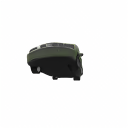

In [24]:
torch.manual_seed(23)
z = torch.randn([1, G.z_dim]).cuda() # Latent Code
with torch.no_grad():
    img = G(z, c, truncation_psi=0.7)[0]
tensor2im(img)

## Sample More Camera Poses

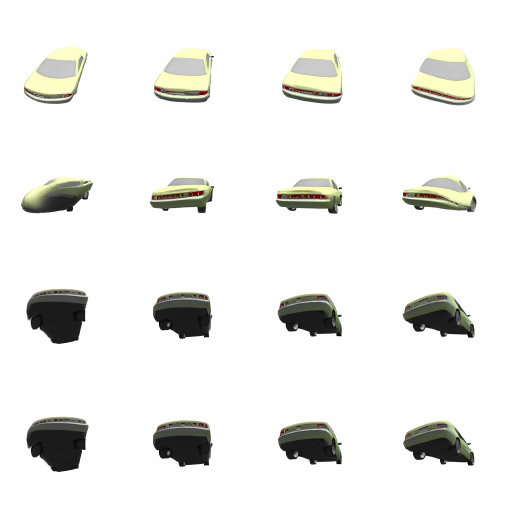

In [25]:
imgs = []
for angle_p in np.linspace(-0.3, 0.4, 4):
    for angle_y in np.linspace(-0.4, 0.4, 4):
        c2w = LookAtPoseSampler.sample(np.pi/2 + angle_y, np.pi + angle_p, cam_pivot, radius=cam_radius, device=device)
        c = torch.cat([c2w.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)
     
        with torch.no_grad():
            img = G(z, c, truncation_psi=0.7)[0]
        imgs.append(tensor2im(img))
image_grid(imgs, 4, 4)